## Style transfer

En este notebook recrearemos los resultados del artículo de [Gatys](https://arxiv.org/abs/1508.06576) de Style-Transfer.

In [85]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [86]:
import fastai
import fastai.basics as fai
import fastai.vision as fv
from fastai.callbacks import hook_outputs, hook_output
#from fastai.utils.mem import *
from pathlib import Path
from shutil import copyfile
import random
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torchvision.models
from torch.utils.data import DataLoader, Dataset
import PIL
from tqdm import tqdm_notebook as tqdm
import gc
import matplotlib.pyplot as plt
import numpy as np

Usaremos VGG para esto

In [87]:
vgg = torchvision.models.vgg16_bn(pretrained=True)

In [88]:
vgg.eval()
fai.requires_grad(vgg, False)

In [90]:
from StyleGAN.samples.split.Layers import num_params

In [91]:
num_params(vgg)

138365992

No nos interesan para nada la parte de "classifier", así que nos quedamos únicamente con las "features"

In [92]:
vgg = vgg.features

In [95]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNor

In [93]:
num_params(vgg)

14723136

In [94]:
gc.collect()

1317

Ahora, queremos usar las capas justo antes a que se pierde información, o sea, justo antes de las max-pools. Podemos ver cuáles capas son así:

In [96]:
good_blocks = [i-1 for i,layer in enumerate(vgg.children()) if isinstance(layer,nn.MaxPool2d)]

In [97]:
good_blocks

[5, 12, 22, 32, 42]

In [98]:
def gram_matrix(x):
    bs,c,h,w = x.shape
    x = x.view(bs, c, h*w)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
class StyleAndContentLoss(nn.Module):
    def __init__(self, model, layer_ids, content_weights, style_weights, style_mult):
        super().__init__()
        self.model = model
        self.important_layers = [self.model[i] for i in layer_ids]
        self.hooks = hook_outputs(self.important_layers, detach=False)
        self.content_weights = content_weights
        self.style_weights = style_weights
        self.criterion = F.l1_loss
        self.style_mult = style_mult

    def extract_features(self, x, clone=False):
        self.model(x)
        features = list(self.hooks.stored)
        
        if clone:
            features = [f.clone() for f in features]
        
        return features
    
    def content_loss(self, A, B):
        return sum([self.criterion(a, b)*w for a, b, w in zip(A, B, self.content_weights)])
    
    def style_loss(self, A, B):
        return sum([self.criterion(gram_matrix(a), gram_matrix(b))*w for a, b, w in zip(A, B, self.style_weights)])
    
    def forward(self, x, content_image, style_image):
        x_features = self.extract_features(x)
        content_features = self.extract_features(content_image, clone=True)
        style_features = self.extract_features(style_image, clone=True)
        
        self.CL = self.content_loss(x_features, content_features)
        self.SL =  self.style_mult*self.style_loss(x_features, style_features)

        return self.CL + self.SL
    
    def __del__(self): 
        self.hooks.remove() # necesario para que deje de guardar las cosas

# Style Transfer
Vamos a empezar con la imagen de paris y la iremos modificando para que tenga el estilo de starry-night.

In [13]:
img_size = (3,400,600)

In [14]:
def show_tensor_as_image(tensor, ncols=5, figsize=10, title = ""):
    plt.figure(figsize=(figsize,figsize))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(utils.make_grid(tensor.detach().cpu()[:ncols*ncols], nrow=ncols, padding=2, normalize=True).cpu(),(1,2,0)))

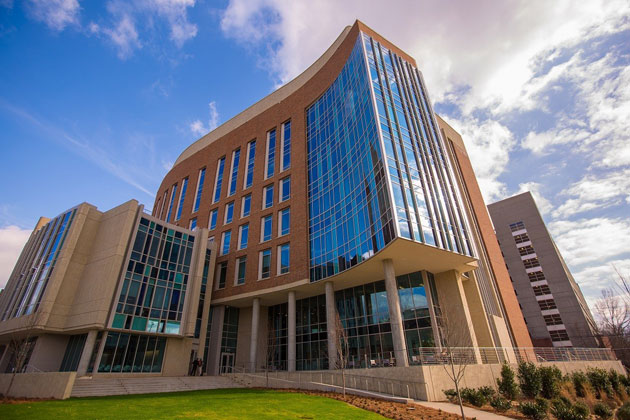

In [15]:
content_img = fv.open_image("building.jpg");
content_img

Ahora iremos modificando poco a poco la imagen para que se parezca a esta:

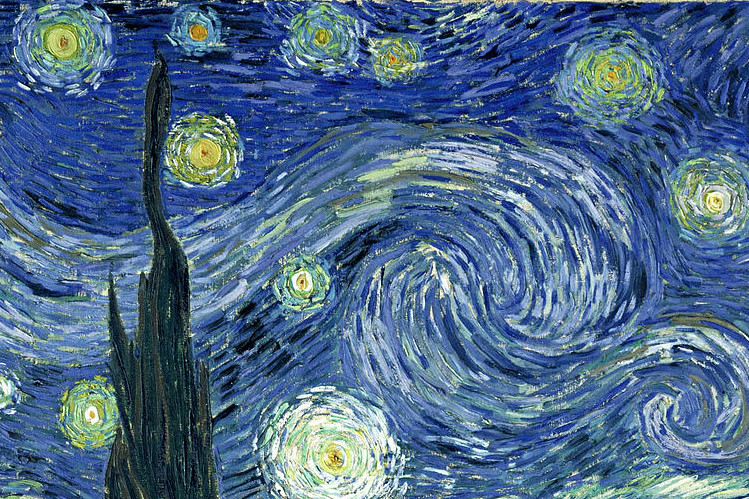

In [16]:
style_img = fv.open_image("starrynightpatch.jpg");
style_img

In [17]:
content_img = content_img.resize(img_size)
style_img = style_img.resize(img_size)

In [18]:
content_img.data.shape

torch.Size([3, 400, 600])

In [19]:
content_img = content_img.data.cuda()
style_img = style_img.data.cuda()
content_img,style_img = content_img.unsqueeze(0),style_img.unsqueeze(0)

In [20]:
content_img = 2.*content_img - 1.
style_img = 2.*style_img - 1.

In [133]:
#img = style_img.clone()
#img = content_img.clone()
img = torch.rand((1,3,img_size[1],img_size[2])).cuda()
img.requires_grad_(True);

In [134]:
img.shape

torch.Size([1, 3, 400, 600])

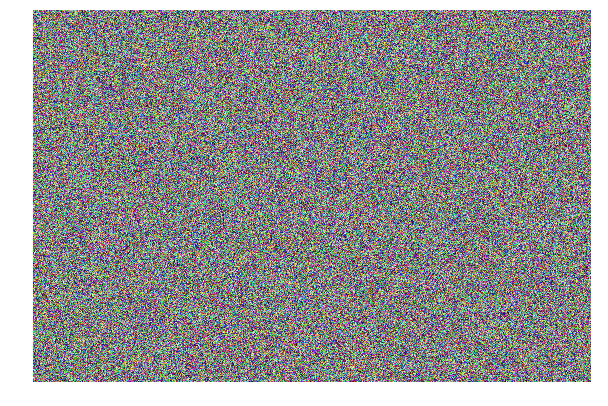

In [135]:
show_tensor_as_image(img)

In [144]:
loss_func = StyleAndContentLoss(vgg,good_blocks,[1,1,3,15,10],[20,15,15,10,4], 2e3).cuda()

In [145]:
def train(num_epochs, lr):
    optim = torch.optim.Adam([img], lr=lr)
    with tqdm(range(num_epochs)) as pbar:
        for epoch in pbar:
            optim.zero_grad()
            loss = loss_func(img,content_img,style_img)
            loss.backward()
            optim.step()
            img.data.clamp_(-1.,1.)
            pbar.set_postfix(loss=loss.item(), style_loss=loss_func.SL.item(), content_loss=loss_func.CL.item())
    

In [146]:
train(200,1e-2)

In [147]:
train(90,1e-1)

In [148]:
train(90,5e-2)


In [149]:
train(200,8e-3)

In [106]:
train(100,5e-4)

In [107]:
train(100,1e-4)

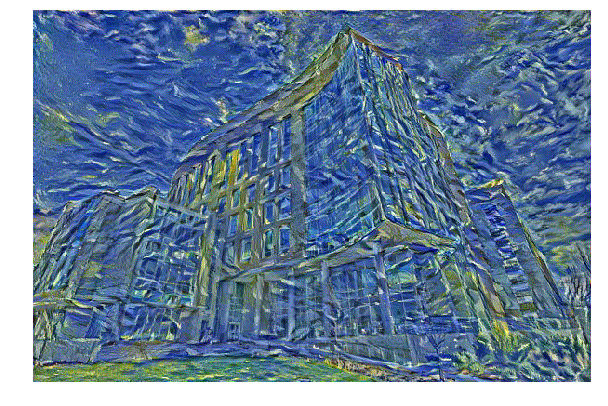

In [150]:
show_tensor_as_image(img)

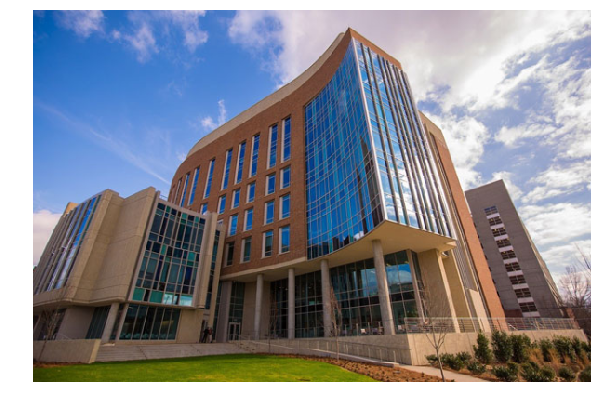

In [110]:
show_tensor_as_image(content_img)

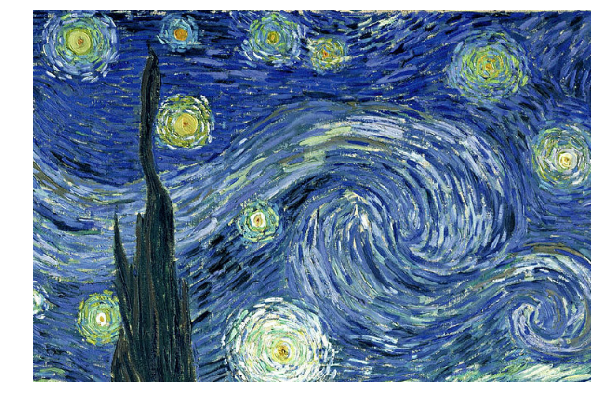

In [111]:
show_tensor_as_image(style_img)